# Segment then align images
Our microscopy images drift signficiantly over time, which frustrates us being able to study how voids move between images.

In [1]:
%matplotlib inline
from rtdefects.segmentation.pytorch import PyTorchSemanticSegmenter
from rtdefects.analysis import analyze_defects
from rtdefects.io import encode_as_tiff
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.optimize import minimize
from functools import lru_cache
from imageio import v3 as iio
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil

/home/lward/miniconda3/envs/rtdefects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
run_directory = '../../../learning-defect-pde/data/8bitTIFF-video32-625C/'
frames_per_drift_point: int = 2  # Decrease to increase the complexity of drift model

Initialize the output directory

In [3]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
out_directory.mkdir(exist_ok=True, parents=True)
(out_directory / 'figures').mkdir(exist_ok=True)

Make a cached function for reading images

In [4]:
imread_fun = lru_cache()(iio.imread)

## Segment the Images and Save Masks to Disk
Segmentation produces a mask that contains the extent of each instance

In [5]:
images = sorted((run_directory).glob('*tif'))
print(f'Found {len(images)} images')

Found 860 images


Run each through seg

In [6]:
out_directory

PosixPath('output/8bitTIFF-video32-625C')

In [7]:
mask_dir = out_directory / 'masks'
if mask_dir.exists():
    shutil.rmtree(mask_dir)
mask_dir.mkdir()

In [8]:
segmenter = PyTorchSemanticSegmenter()

In [9]:
defect_details = []
for image in tqdm(images):
    # Run segmentation
    image_data = iio.imread(image)
    image_data = segmenter.transform_standard_image(image_data)
    mask = segmenter.perform_segmentation(image_data)

    # Save and analyze masks
    defect_details.append(analyze_defects(mask))
    mask_path = mask_dir / image.with_suffix('.tiff').name
    defect_details[-1]['image_path'] = str(image)
    defect_details[-1]['mask_path'] = str(mask_path)
    mask_path.write_bytes(encode_as_tiff(mask))
defect_details = pd.DataFrame(defect_details)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860/860 [08:11<00:00,  1.75it/s]


## Determine the correction
The idea is to determine drift by computing the [cross-correlation between the two images](https://en.wikipedia.org/wiki/Cross-correlation#/media/File:Cross_correlation_animation.gif). 
The largest peak in the cross-correlation will correspond to the translation that leads to the greatest overlap between the two images.
Due to same [math I don't understand](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Circular_convolution_theorem_and_cross-correlation_theorem), you can compute this cross-correlation very quickly using Fourier Transforms with [SciPy](https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images).

In [10]:
images = defect_details['mask_path']

In [11]:
image_1 = imread_fun(images[0])
image_2 = imread_fun(images[16])

In [12]:
def compute_drift(image_1: np.ndarray, image_2: np.ndarray) -> np.ndarray:
    """Compute the drift between two different frames
    
    Args:
        image_1: Starting image, assumed to be in <defects>x<width>x<height>
        image_2: Next image, assumed to be in <defects>x<width>x<height>
    Returns:
        - The optimal translation between the two images
        - Convolution used to make the judgement
    """

    # Get a 2D version of the images
    #  We pick the maximum type of each image
    if min(image_1.shape[0], image_2.shape[0]) == 0:
        return [0, 0], None
    image_1 = image_1.max(axis=0)
    image_2 = image_2.max(axis=0)
    
    # Compute the correlations between the two images using FFT
    #  You must reverse the second signal/image for this trick
    image_1 = image_1 > 0
    image_2 = image_2 > 0
    conv = fftconvolve(image_1, image_2[::-1,::-1], mode='same')
    
    # Find the location of the maximum
    peak_loc = np.unravel_index(np.argmax(conv), conv.shape)
    
    # Find its deplacement from the image center, that's the location
    drift = [peak_loc[1] - conv.shape[0] // 2 , peak_loc[0] - conv.shape[1] // 2]
    return -np.array(drift), conv
drift, conv = compute_drift(image_1, image_2)
drift

array([ 4, 12])

We can see the image drifted to the left (-x) and down (y)

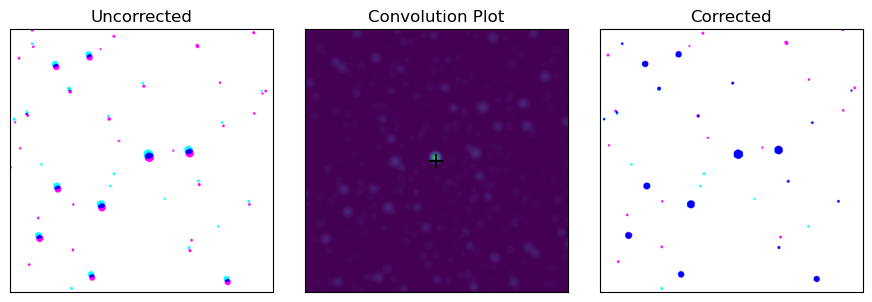

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
image[:, :, 0] -= np.array(image_1.any(axis=0) * 255, dtype=np.uint8)
image[:, :, 1] -= np.array(image_2.any(axis=0) * 255, dtype=np.uint8)
axs[0].imshow(image)
axs[0].set_title('Uncorrected')

# Plot the convolution
axs[1].scatter([image_1.shape[2] // 2], [image_1.shape[1] // 2], marker='+', s=100., color='k')
axs[1].imshow(conv)
axs[1].set_title('Convolution Plot')

# Plot the re-registered images
affine = AffineTransform(translation=drift)
image_2_shift = np.array(warp(image_2.any(axis=0).astype(float) * 255, affine), dtype=np.uint8)
image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
image[:, :, 0] -= np.array(image_1.any(axis=0) * 255, dtype=np.uint8)
image[:, :, 1] -= np.array(image_2_shift, dtype=np.uint8)
axs[2].imshow(image)
axs[2].set_title('Corrected')

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation.png', dpi=320)

The light and dark blue in the left image are the voids at different times. You can see the pattern drifts "up to the right" between them, which is reflected in the peak of the cross-correlation being up and to the right. 
Applying that transformation yields the two mapped directly atop each other.

## Apply to the whole stack
We can now compute the drift between successive images in the stack to get the total drift over time

In [14]:
stepwise_drifts = [
    compute_drift(imread_fun(x), imread_fun(y))[0]
    for x, y in tqdm(zip(images, images[1:]))
] 

859it [04:07,  3.47it/s]


Plot how the drift goes over time.

In [15]:
stepwise_drifts = np.vstack([[0, 0], stepwise_drifts])  # Initial frame has no drift

In [16]:
total_drift = np.cumsum(stepwise_drifts, axis=0)

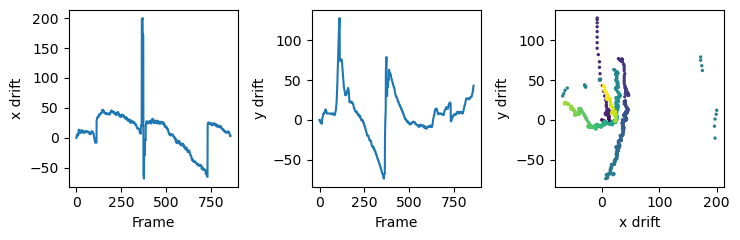

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=2)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft.png', dpi=320)

This gives a quick estimate of drift by looking at individual pairs. One thing you will note are strong "jumps" between frames.

## Looking ahead multiple frames
The drift might be imperceptable between between adjacent frames but clearer for those far apart.
Judging image drift with frames several spaces apart will be able to give a better estimate, but at the expense of worse 

In [18]:
offsets = list(range(0, 20, 5))
drifts = [
    compute_drift(image_1, imread_fun(images[i]))[0] 
    for i in tqdm(offsets)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.88it/s]


In [19]:
drifts = np.array(drifts)

Text(0, 0.5, 'Drifts')

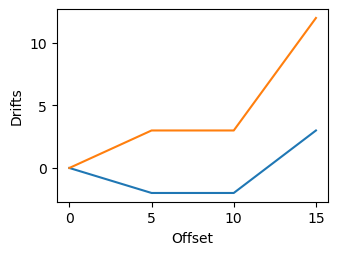

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(offsets, drifts[:, 0], label='x')
ax.plot(offsets, drifts[:, 1], label='y')

ax.set_xlabel('Offset')
ax.set_ylabel('Drifts')

The drift is probably nonlinear given that the drifts to not change linearly with offset. So, it is not likely that we can just assume the drift 1 step ahead is $1/N$ times the difference.

## Multi-Reference Point Drift Evaluation
Instead of relying on measuring the drift at each frame, we are going to fit a single function which explains the observed drift between many pairs of frames.
This will make it possible to include drifts computed between frames which are farther apart, where the estimates of drift are more accurate.

In [21]:
drift_pairs = []
for frame_id in tqdm(range(len(images))):
    image_1 = imread_fun(images[frame_id])
    for offset in [8]:
        frame_2_id = frame_id + offset
        if frame_2_id >= len(images):
            break
        image_2 = imread_fun(images[frame_id + offset])
        drift, _ = compute_drift(image_1, image_2)
        drift_pairs.append({
            'frame_1': frame_id,
            'frame_2': frame_2_id,
            'offset': offset,
            'drift_x': drift[0],
            'drift_y': drift[1]
        })
drift_pairs = pd.DataFrame(drift_pairs)
print(f'Computed {len(drift_pairs)} drift pairs')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860/860 [04:28<00:00,  3.20it/s]


Computed 852 drift pairs


We then will fit a model which explains the observed drift for each offset

In [22]:
def get_drift_model(drift_points: np.ndarray, n_images: int, kind: str = 'linear'):
    """Make a model which predicts drift as a function of frame number.
    
    Takes a 2D array of drift points and assumes they are equally-spaced
    segments where the last row corresponds to the last frame in the series.
    
    We pre-prepend a drift of [0, 0] to the beginning of the drift points
    before fitting the drift as a function of frame index
    
    Args:
        drift_points: Equally-spaced estimates of drift
        n_images: Number of images in the stack
        kind: Kind of interpolator
    Returns:
        A single function which generates the drift at a single point
    """

    # Guess the points for each frame
    frame_points = np.linspace(0, n_images, drift_points.shape[0] + 1)
    
    # Prepend a point specifying drift is zero at frame 0
    drift_fit = np.concatenate(([[0, 0]], drift_points), axis=0)
    
    # Make the interpolators
    return interp1d(frame_points, drift_fit, kind=kind, axis=0)

In [23]:
drift_model = get_drift_model(np.array([[0, 0]]), len(images))

In [24]:
def assess_drift_model(model, drift_pairs: pd.DataFrame) -> float:
    """Score the quality of a drift model given the drift between pairs of points
    
    Args:
        model: Model to be evaluated
        drift_pairs: The drift measured at different points
    Returns:
        Mean difference between predicted and actual drift
    """
    
    # Predict the drift of each frame
    frame_1_drift = model(drift_pairs['frame_1'])
    frame_2_drift = model(drift_pairs['frame_2'])
    
    # Get the difference between the predicted and observed drift for each pair
    pred_drift = frame_2_drift - frame_1_drift
    difference = drift_pairs[['drift_x', 'drift_y']].values - pred_drift
    return np.abs(difference).mean()

In [25]:
assess_drift_model(drift_model, drift_pairs)

7.288145539906103

In [26]:
def fit_model(drift_pairs: pd.DataFrame, n_points: int, num_images: int, kind='linear'):
    """Fit a drift model with a certain number of points in each direction
    
    Args:
        drift_pairs: Observed drift between pairs of frames
        n_points: Number of points to use to describe the function
        num_images: Number of images in the series
    Returns:
        A function describing the drift
    """
    
    # Start with "no drift" as the initial guess
    initial_guess = np.zeros((n_points, 2))
    
    # The function to minimize is the observed drift error
    def function(x: np.ndarray) -> float:
        points = x.reshape((-1, 2))
        model = get_drift_model(points, num_images, kind='cubic')
        return assess_drift_model(model, drift_pairs)
    
    result = minimize(function, initial_guess.flatten(), method='BFGS')

    # Make the function
    model = get_drift_model(result.x.reshape((-1, 2)), num_images, kind=kind)
    return model, result

In [27]:
%%time
drift_model, result = fit_model(drift_pairs, len(images) // frames_per_drift_point, len(images))  # One point every 4 frames

CPU times: user 5h 10s, sys: 12min 3s, total: 5h 12min 13s
Wall time: 1h 3min 19s


In [28]:
print(f'Improved fitness to {result.fun}')

Improved fitness to 0.7697079990573228


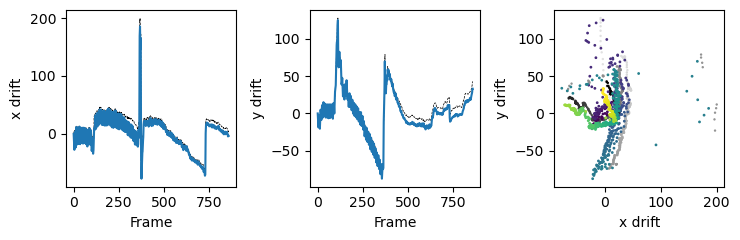

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

frame = np.arange(len(images))
model_drift = drift_model(frame)
for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i], 'k--', lw=0.5)
    ax.plot(model_drift[:, 1- i], '-')
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=0.5, cmap='gray_r')
axs[2].scatter(model_drift[:, 1], model_drift[:, 0], c=np.arange(total_drift.shape[0]), s=1)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft-multi-refrence.png', dpi=320)

The drift seems to have a general trend but is more aggresive.

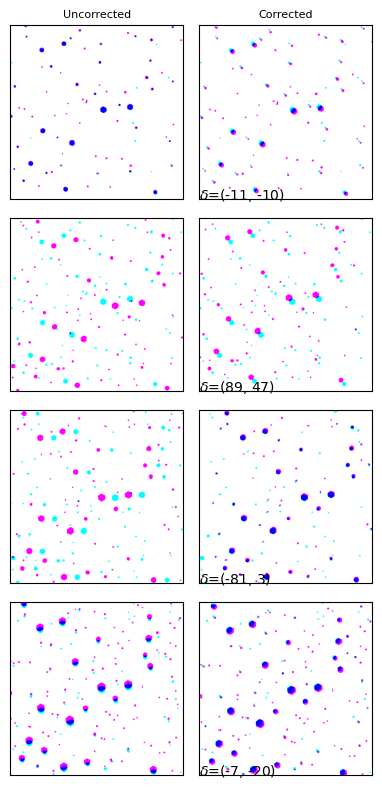

In [30]:
fig, axxs = plt.subplots(4, 2, figsize=(4, 8))


axxs[0, 0].set_title('Uncorrected', fontsize=8)
axxs[0, 1].set_title('Corrected', fontsize=8)

for axs, (ind_1, ind_2) in zip(axxs, [(30, 60), (60, 120), (120, 240), (240, 480)]):
    # Load the masks
    image_1 = imread_fun(images[ind_1])
    image_2 = imread_fun(images[ind_2])
    
    # Estimate the relative drift
    drift = drift_model(ind_2) - drift_model(ind_1)
    
    for ax in axs:
        ax.set_yticks(ax.set_xticks([]))

    # Plot the original and new overlapped
    image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
    image[:, :, 0] -= (image_1.any(axis=0) * 255).astype(np.uint8)
    image[:, :, 1] -= (image_2.any(axis=0) * 255).astype(np.uint8)
    axs[0].imshow(image)

    # Plot the re-registered images
    affine = AffineTransform(translation=drift)
    image_2_shift = np.array(warp(image_2.any(axis=0), affine) * 255, dtype=np.uint8)
    image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
    image[:, :, 0] -= (image_1.any(axis=0) * 255).astype(np.uint8)
    image[:, :, 1] -= image_2_shift.astype(np.uint8)
    axs[1].imshow(image)
    axs[1].text(0, 0, f'$\delta$=({drift[0]:.0f}, {drift[1]:.0f})', transform=axs[1].transAxes)
    
    

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation-multi-reference.png', dpi=320)

## Save Updated Model
Save it to disk for later use

In [31]:
out_path = out_directory / 'drifts-fft.csv'
pd.DataFrame(model_drift, columns=['x', 'y']).to_csv(out_path, index_label='frame')

## Update the Void Locations
The void locations in the defect details files with the run should be updated too.

In [32]:
defect_details['positions_corrected-fft'] = [(x - y) if len(x) > 0 else x for x, y in zip(defect_details['positions'], model_drift)]
defect_details['drift'] = total_drift.tolist()

In [33]:
defect_details.to_json(out_directory / f'defect-details.json', orient='records', lines=True)